# LSTM Models for TKN Prediction in Influent Wastewater

Model Iteration No. 2 - This code uses top 3 SHAP values as project feature inputs (P-TOT, CBOD5, VTS).

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
# from utils import * 

import sklearn as sk
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [3]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

In [4]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

# Import the Data

In [215]:
influent = pd.read_excel(r"C:\Users\18455\EAEE4000_ML_Jupyter\EAEE4000_WW_Prediction\Appendix_A_Preprocessing_and_DataReview\raw_influent.xlsx")
influent['Year']= influent['Date'].apply(lambda x: x.year)
influent['Year'] = influent['Year'].astype(int)
influent

,Unnamed: 0,Date,BOD5,CBOD5,SS,VSS,TS,VTS,TKN,Nitrates,P-TOT,P-SOL,Year
0,2672,2008-01-01,67,55,82,64,1994,188,18.53,0.72,2.65,1.155,2008
1,2673,2008-01-02,77,57,70,61,1274,196,19.87,0.85,4.22,2.849,2008
2,2674,2008-01-03,94,70,84,69,1096,220,21.49,0.81,5.53,3.809,2008
3,2675,2008-01-04,93,64,72,54,1003,242,19.32,0.65,6.19,4.107,2008
4,2676,2008-01-05,107,75,118,90,1317,280,17.13,0.31,4.16,2.183,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4378,7706,2019-12-27,0,0,79,61,554,174,14.00,0.66,3.05,1.310,2019
4379,7707,2019-12-28,62,51,48,37,570,130,18.00,0.76,4.47,2.170,2019
4380,7708,2019-12-29,189,115,340,224,962,340,17.00,0.49,4.55,1.240,2019
4381,7709,2019-12-30,74,47,99,68,656,164,14.00,0.88,2.70,1.070,2019


# Prepare the Training Data

See top 3 project input features used here.

In [216]:
# Prepare the training set
X = influent[['VTS','CBOD5','P-TOT']]
Y = influent[['TKN']]
X_train_df, X_test_df, Y_train_df, Y_test_df = train_test_split(X, Y,
        test_size = 0.2, random_state=2, shuffle=False)

In [217]:
# Normalize the data
mean_x, std_x = X_train_df.mean(), X_train_df.std()
mean_y, std_y = Y_train_df.mean(), Y_train_df.std()

X_train_df = (X_train_df - mean_x)/std_x
X_test_df  = (X_test_df - mean_x)/std_x

Y_train_df = (Y_train_df - mean_y)/std_y
Y_test_df  = (Y_test_df - mean_y)/std_y

X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

X_test = X_test_df.to_numpy()
Y_test = Y_test_df.to_numpy()

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape, )

(3506, 3) (3506, 1)
(877, 3) (877, 1)


# Reshape the Data for LSTM Model Input

In [218]:
# Reshape the data to prepare for LSTM Model use.
# Format: samples, time steps, features

X = X_train
Y = Y_train

Xt = X_test
# Yt = Y_test

X_reshape = []
Y_reshape = []
Xt_reshape = []
# Yt_reshape = []

sequence_length = 4 # time step

In [219]:
for index in range(len(X)- sequence_length):
    X_reshape.append(X[index: index + sequence_length])
X_reshape = np.array(X_reshape)
X_train = X_reshape
print(X_train.shape)

(3502, 4, 3)


In [220]:
for index in range(len(Y) - sequence_length):
    Y_reshape.append(Y[index: index + sequence_length])
Y_reshape = np.array(Y_reshape)
Y_train = Y_reshape
print(Y_train.shape)

(3502, 4, 1)


In [221]:
for index in range(len(Xt) - sequence_length):
    Xt_reshape.append(Xt[index: index + sequence_length])
Xt_reshape = np.array(Xt_reshape)
X_test = Xt_reshape
print(X_test.shape)

(873, 4, 3)


In [222]:
Y_test = Y_test_df.iloc[4:]
print(Y_test.shape)

(873, 1)


# Set Hyperparameters and Model Architecture

In [282]:
# set hyperparameters
n_neuron       = 24 # increasing neurons resulted in worse loss
activation     = 'relu' # best performing act function
num_epochs     = 25
learning_rate  = 0.005
minibatch_size = 50 
model_num      = 1
params         = 3 #  these are the number of features included in the reshaped data (samples, time step, features)

In [283]:
lstm_model = Sequential()

lstm_model.add(LSTM(n_neuron,input_shape=(sequence_length, params),return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(n_neuron,activation='Softmax'))
#lstm_model.add(Dense(n_neuron,activation=activation)), Not used - determined additional layers did not improve accuracy.
#lstm_model.add(Dense(n_neuron,activation=activation))
#lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(1)) #, activation='softmax') 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [284]:
lstm_model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 4, 24)             2688      
                                                                 
 lstm_67 (LSTM)              (None, 24)                4704      
                                                                 
 dense_99 (Dense)            (None, 24)                600       
                                                                 
 dense_100 (Dense)           (None, 24)                600       
                                                                 
 dense_101 (Dense)           (None, 1)                 25        
                                                                 
Total params: 8,617
Trainable params: 8,617
Non-trainable params: 0
_________________________________________________________________


# Evaluate the Model

In [285]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = lstm_model.fit(X_train, Y_train, 
                    #batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1, 
                    callbacks       = [early_stop])

Epoch 1/25
88/88 [==============================] - 5s 16ms/step - loss: 0.6659 - val_loss: 1.5020
Epoch 2/25
88/88 [==============================] - 1s 9ms/step - loss: 0.5996 - val_loss: 1.3957
Epoch 3/25
88/88 [==============================] - 1s 9ms/step - loss: 0.5864 - val_loss: 1.3214
Epoch 4/25
88/88 [==============================] - 1s 9ms/step - loss: 0.5787 - val_loss: 1.2482
Epoch 5/25
88/88 [==============================] - 1s 9ms/step - loss: 0.5749 - val_loss: 1.2054
Epoch 6/25
88/88 [==============================] - 1s 9ms/step - loss: 0.5673 - val_loss: 1.1524
Epoch 7/25
88/88 [==============================] - 1s 10ms/step - loss: 0.5581 - val_loss: 1.1025
Epoch 8/25
88/88 [==============================] - 1s 9ms/step - loss: 0.5501 - val_loss: 1.0652
Epoch 9/25
88/88 [==============================] - 1s 9ms/step - loss: 0.5457 - val_loss: 1.0023
Epoch 10/25
88/88 [==============================] - 1s 9ms/step - loss: 0.5438 - val_loss: 0.9654
Epoch 11/25
88/88

In [286]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
            label='Train loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
            label='Val loss')
    plt.legend()

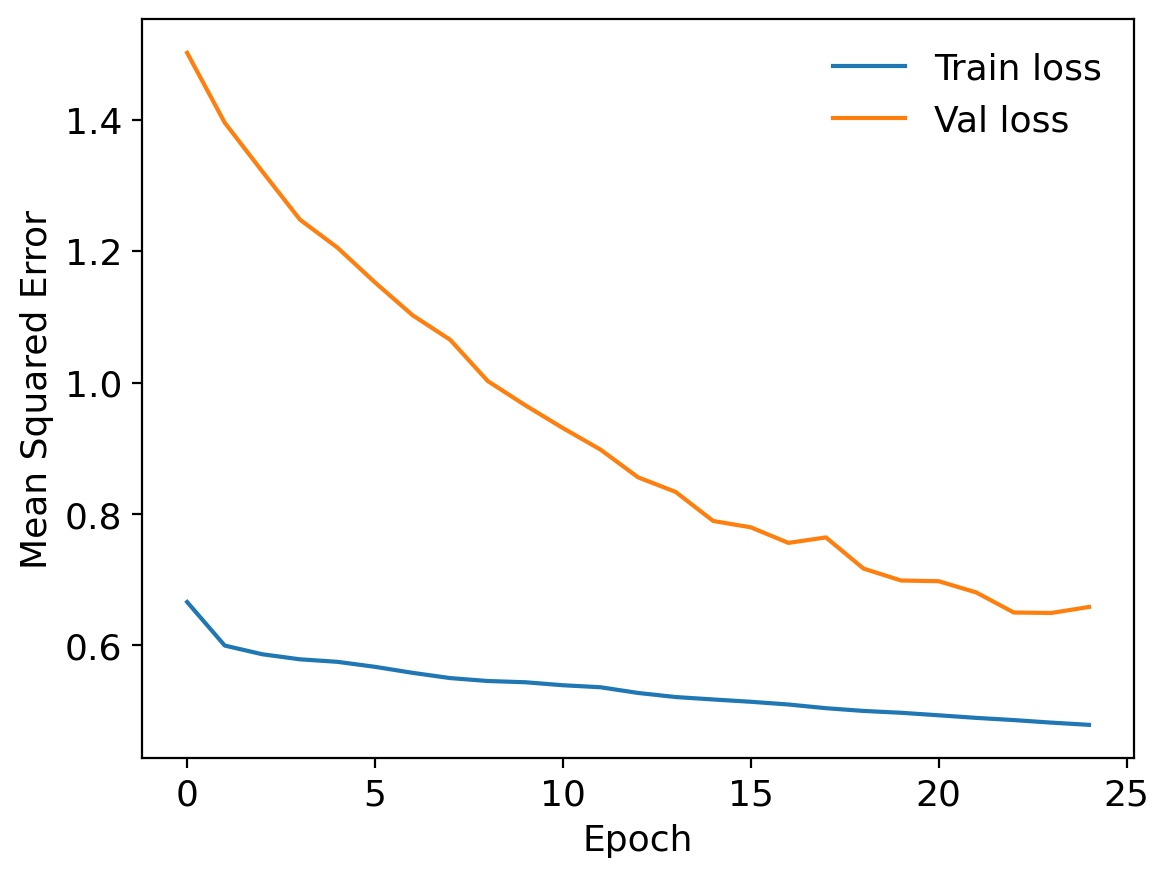

In [287]:
plot_history(history)

# Make Predictions

In [288]:
print(Y_test.shape)

(873, 1)


In [289]:
print(X_test.shape)

(873, 4, 3)


In [290]:
y_test_predict = lstm_model.predict(X_test) # check how it does for X_train set...if still getting same numbers may be over/underfitting
y_test_predict

28/28 [==============================] - 0s 3ms/step


array([[ 7.86533654e-01],
       [ 9.94383395e-01],
       [ 9.95995760e-01],
       [ 1.05756485e+00],
       [ 1.02862763e+00],
       [ 1.02470553e+00],
       [ 1.03647208e+00],
       [ 1.04897404e+00],
       [ 9.67858970e-01],
       [ 1.05190110e+00],
       [ 1.05225837e+00],
       [ 1.11026156e+00],
       [ 1.22185647e+00],
       [ 1.21165729e+00],
       [ 1.19454098e+00],
       [ 1.11956167e+00],
       [ 1.10025954e+00],
       [ 9.47507262e-01],
       [ 1.00019217e+00],
       [ 1.03240895e+00],
       [ 1.04496551e+00],
       [ 1.14251804e+00],
       [ 1.18571889e+00],
       [ 9.41414654e-01],
       [ 8.69795740e-01],
       [ 8.54249358e-01],
       [ 8.49172831e-01],
       [ 9.31278229e-01],
       [ 7.76247442e-01],
       [ 7.58684993e-01],
       [ 6.67519808e-01],
       [ 6.49264395e-01],
       [ 7.17019975e-01],
       [ 6.30394042e-01],
       [ 4.42156196e-01],
       [ 4.04307127e-01],
       [ 5.38763404e-01],
       [ 4.62054789e-01],
       [ 3.8

In [291]:
print(y_test_predict.shape)

(873, 1)


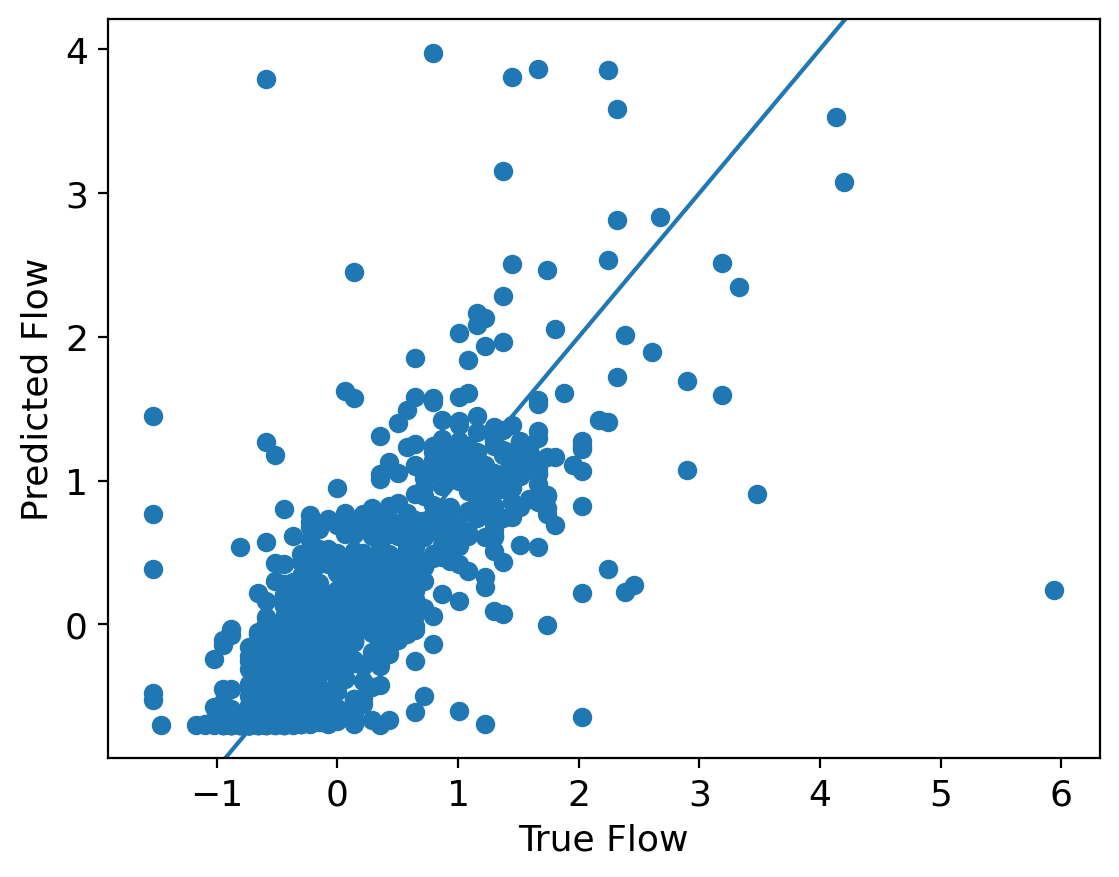

In [292]:
plt.scatter(Y_test, y_test_predict) # this is where y_test comes into play...to backcheck the correct answers
plt.xlabel('True Flow')
plt.ylabel('Predicted Flow')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [293]:
# Calculate predictions & associated Mean Squared Error
mse(Y_test, y_test_predict)

0.3618784983420727

In [294]:
# print out the prediction scores
print('MSE: {}'.format(mse(Y_test, y_test_predict)))
print('RMSE: {}'.format(np.sqrt(mse(Y_test, y_test_predict))))
print('MAE: {}'.format(mae(Y_test, y_test_predict)))
print('R-SQ: {}'.format(r2_score(Y_test, y_test_predict)))

MSE: 0.3618784983420727
RMSE: 0.6015633784914709
MAE: 0.3956994993879778
R-SQ: 0.4937398555019117
